## Аминокислотные последовательности антител

<img src="https://i0.wp.com/www.blopig.com/blog/wp-content/uploads/2013/07/Antibody1.png?ssl=1" style="background:white" width="600"/>

Как и любые белки́, [антитела](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%82%D0%B8%D1%82%D0%B5%D0%BB%D0%B0) состоят из [аминокислот](https://shorturl.at/Wc6V4), соединённых пептидными связями.

Каждой аминокислоте соответствует однобуквенный код (A - аланин, C - цистеин, D - аспартат, и т.д.), поэтому мы можем компактно записывать первичную структуру белков (то есть просто цепочку аминокислот) в виде строк.

Сегодня нам предстоит решить две задачи:
1. Обучить модель-классификатор, позволяющую по аминокислотной последовательности понять, из какого животного было получено антитело
2. Обучить модель-генератор новых антител с условием на биологический вид

#### Подготовим данные

В нашем наборе данных присутствуют антитела (точнее - небольшие фрагменты тяжелых цепей антител, VH-домены, непосредственно участвующие в связывании инородных молекул - антигенов), полученные из образцов пяти биологических видов: человек, макака-резус, мышь, кролик и верблюд.

In [1]:
import pandas as pd

antibodies = pd.read_csv("../datasets/antibodies.csv").sample(frac=1.0)
antibodies.head(10)

,sequence,species
942,EVQLQQSGPELVKPGASVKISCKASGYTFTDYYMNWVKQSHGKSLE...,Human
3021,QVQLQESGPGLVKPSETLSLTCTVSGASISYNWWSWIRKPPGKGLE...,Rhesus
2439,SVKVSCKSSGYSFTAYHLHWVRQAPGQGLEWMGWIKPDSDDTYYAH...,Mouse
1864,HVQLVESGGGSVQAGGSLRLSCAASGYTYSSFCIGWFRQAPGMERT...,Camel
398,QVQLQQSGPELVKPGASVKISCKASGYAFSSSWMNWVKQRPGMGLE...,Human
1634,VQLVESGGGSVEAGGSLRLSCAVSGYTYPTRCMAWFRQAPGKEREA...,Camel
1116,VQLVESGGGSVQAGGSLRLSCAASGFTFSPPCMGWFRQAPGKEREG...,Camel
3952,QVPLQGSGPRLLRPSETLSPSCSVAGVSVTADLWSWLRPSPGTGLE...,Rhesus
195,EVQLQQSGPVLVKPGPSVKISCKASGFTFTDYCIHWVKQSHGKSLE...,Human
2037,SVKVSCKASGYTFTTYYMHWVRQAPGQGLEWMGMISPSGHNSMYAQ...,Mouse


Создадим словари для аминокислот, специальных токенов и биологических видов:

In [2]:
SPECIAL_TOKENS = "_?\n"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWYX"
VOCAB = {char: i for i, char in enumerate(SPECIAL_TOKENS + AMINO_ACIDS)}
SPECIES = {name: i for i, name in enumerate(sorted(antibodies["species"].unique()))}
SPECIES

{'Camel': 0, 'Human': 1, 'Mouse': 2, 'Rabbit': 3, 'Rhesus': 4}

In [4]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split


class AntibodiesDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.sequences = [
            [1] + [VOCAB[char] for char in s] + [2] for s in df["sequence"]
        ]
        self.labels = [SPECIES[label] for label in df["species"]]

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.sequences[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.sequences)

    @staticmethod
    def collate_fn(batch: list[tuple[list[int], int]]) -> tuple[Tensor, Tensor]:
        encoded, lang_ids = zip(*batch)
        max_len = max(map(len, encoded))
        x = torch.zeros((len(encoded), max_len), dtype=int)
        for i, seq in enumerate(encoded):
            x[i, : len(seq)] = torch.tensor(seq)

        return x, torch.tensor(list(lang_ids))


labels = sorted(antibodies["species"].unique())
dataset = AntibodiesDataset(antibodies)
train_dataset, test_dataset = random_split(
    dataset, [4500, 500], torch.Generator().manual_seed(42)
)
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  4500
Test size:  500


In [5]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

#### Задание 1 (6 баллов). Классификация антител по биологическим видам

Мы начнём с нашей рекуррентной ячейки с последней практики:

In [6]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

**1.1. (1 балл)** Реализуйте архитектуру модели, которая по входной последовательности будет давать вероятностное распределение над биологическими видами.
Она даже немного проще, чем модель для генерации: линейный блок-классификатор мы применяем только к последнему скрытому состоянию (когда вся последовательность обработана).

**1.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики точности классифкации для обучающей и тестовой выборок.

**1.3. (3 балла)** Реализуйте другой вид рекуррентной ячейки (GRU или LSTM, см. практику), обучите модель на его основе, выведите графики точности. Как изменилась точность модели и скорость обучения?


Указание: используйте небольшие модели, с размером скрытого слоя 64

In [12]:
class RNN_easy(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = RNNCell(hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden

        # lm_head: B x T x hidden -> B x T x V
        return self.lm_head(h)

In [8]:
from typing import Callable, Any
import lightning as L

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from PIL.Image import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]

class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        transform: Callable[[Image], Tensor] = transforms.ToTensor(),
        num_workers: int = 0,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transform
        self.num_workers = num_workers

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            train_dataset, 
            batch_size=32,
            shuffle=True, 
            collate_fn=dataset.collate_fn
            )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            test_dataset, 
            batch_size=32, 
            shuffle=False, 
            collate_fn=dataset.collate_fn
            )

In [50]:
from typing import Any

from lightning.pytorch.utilities.types import STEP_OUTPUT

train_plot = []
val_plot = []

class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:

        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[5, 10, 15],
                gamma=0.1,
            ),
        }
    
    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics["train_loss"]
        train_plot.append(train_loss.to(device='cpu').detach().numpy())

    def on_validation_epoch_end(self) -> None:
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_plot.append(val_loss.to(device='cpu').detach().numpy())
        print(f" Val. Loss: {val_loss:.4f}")

In [53]:
train_plot = []
val_plot = []

lit_module = Lit(
    model=RNN_easy(vocab_size=len(VOCAB)), learning_rate=0.001
)

datamodule = Datamodule(batch_size=32, num_workers=0)
datamodule.setup(stage="fit")

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=30,
    limit_train_batches=None,
    limit_val_batches=None,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(
    model=lit_module,
    datamodule=datamodule,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | RNN_easy | 10.2 K | train
-------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.6145


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.3173


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2647


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2532


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.3342


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2325


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2213


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2219


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2207


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2193


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2205


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2206


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2198


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2185


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2187


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2185


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2186


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2184


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2184


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2188


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2184


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2183


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2182


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


 Val. Loss: 1.2184


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2184


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.2183953523635864     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.2183953523635864}]

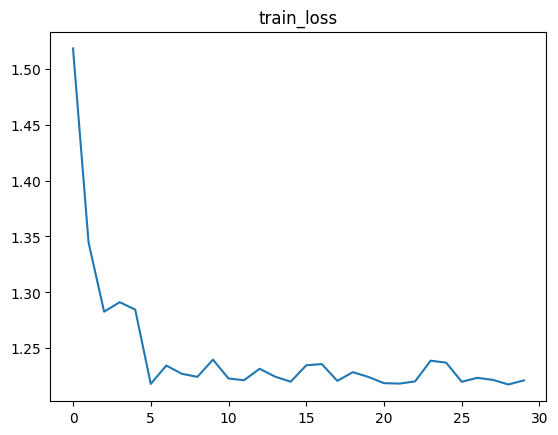

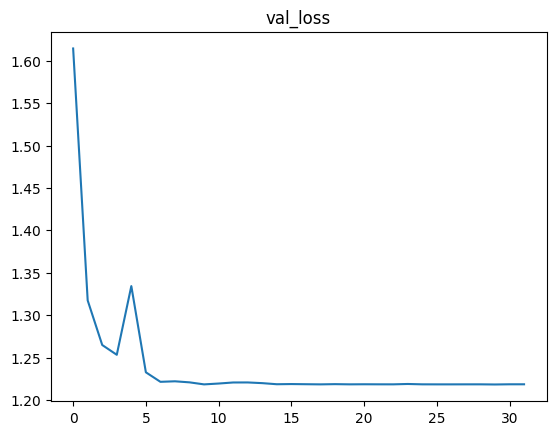

In [55]:
import matplotlib.pyplot as plt

plt.title("train_loss")
plt.plot(range(len(train_plot)), train_plot)
plt.show()

plt.title("val_loss")
plt.plot(range(len(val_plot)), val_plot)
plt.show()

In [54]:
class GRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W_r = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.W_z = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.W = nn.Linear(input_dim + hidden_dim, hidden_dim)


    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        z = F.sigmoid(self.W_z(torch.cat([x, h], dim=1)))
        r = F.sigmoid(self.W_r(torch.cat([x, h], dim=1)))
        h_ = F.tanh(self.W(torch.cat([x, h * r], dim=1)))
        h_ = (1 - z) * h + z * h_
        return h_

In [56]:
class RNN_med(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = GRUCell(hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden

        # lm_head: B x T x hidden -> B x T x V
        return self.lm_head(h)

In [57]:
train_plot = []
val_plot = []

lit_module = Lit(
    model=RNN_med(vocab_size=len(VOCAB)), learning_rate=0.001
)

datamodule = Datamodule(batch_size=32, num_workers=0)
datamodule.setup(stage="fit")

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=30,
    limit_train_batches=None,
    limit_val_batches=None,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(
    model=lit_module,
    datamodule=datamodule,
)

/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | RNN_med | 26.7 K | train
------------------------------------------
26.7 K    Trainable params
0         Non-trainable params
26.7 K    Total params
0.107     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


 Val. Loss: 1.5924


/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.1870


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.4116


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.1096


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0558


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0475


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0422


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0385


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0357


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0368


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0316


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0317


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0321


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0329


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0329


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0337


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0336


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0335


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0334


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0332


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0330


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0328


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0329


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0328


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0327


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0325


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0327


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0328


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0327


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0325


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


 Val. Loss: 0.0324


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.0324


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.032403457909822464    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.032403457909822464}]

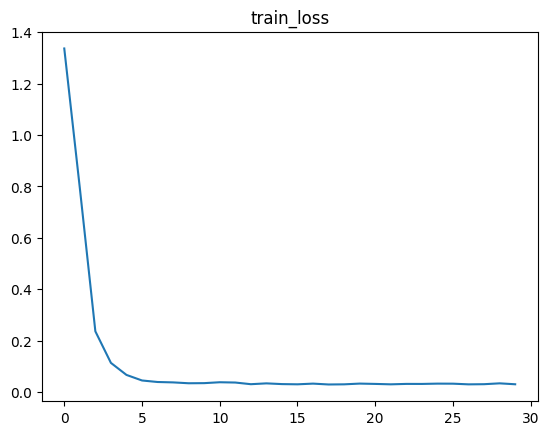

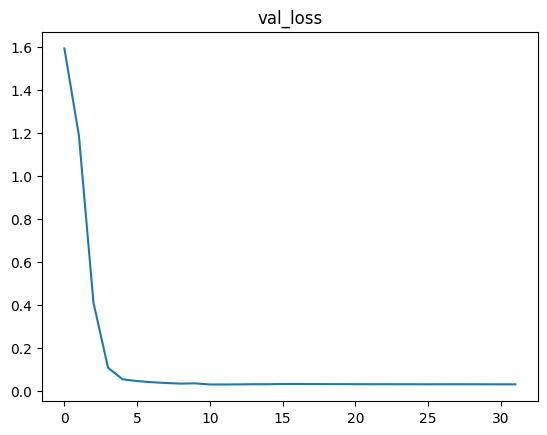

In [58]:
plt.title("train_loss")
plt.plot(range(len(train_plot)), train_plot)
plt.show()

plt.title("val_loss")
plt.plot(range(len(val_plot)), val_plot)
plt.show()

Точность и скорость обучения сильны возросли

#### Задание 2 (8 баллов + 4 бонусных). Генерация антител

Поиграем за B-лимфоцит и попробуем создать новые антитела.

Модель - почти полная копия модели с практики, но есть дополнительное условие: теперь кроме текущего токена и предыдущего скрытого состояния пусть наша ячейка принимает ещё метку биологического вида, к которому должно относиться антитело, вроде такого:

In [94]:
class ConditionalRNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int, class_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)

    def forward(self, x: Tensor, c: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim: эмбеддинг последнего токен
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        h = torch.cat([x, c, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

**2.1. (2 балла)** Реализуйте архитектуру модели для генерации антител символ за символом

**2.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики функции ошибки.

**2.3. (4 балла)** Сгенерируйте с помощью модели по 20 антител для каждого биологического вида в отдельных ячейках, выведите их в ноутбуке. Воспользуйтесь функцией `get_sequence_score` (ниже), чтобы посчитать сходство ваших антител с природными (вернее - очень грубую оценку). Посчитайте, сколько антител из сгенерированных вами имеют оценку 0.55 и выше для каждого биологического вида.

**2.4. (Бонус 4 балла)** Повторите пункты 2.2 и 2.3, но используйте другой тип рекуррентной ячейки (GRU или LSTM).


In [101]:

class RNN_max(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, class_dim=len(SPECIES)) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.embed_class = nn.Embedding(class_dim, 8)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = ConditionalRNNCell(hidden_dim, hidden_dim, 8)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        c = self.embed_class(c)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        logits = [] # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, c, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x hidden
            logits.append(y)
            # save prediction for step t + 1

        # lm_head: B x T x hidden -> B x T x V
        return torch.cat(logits, dim=1)



In [102]:
class LitMax(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:

        x, y = batch
        y_hat = self.model(x, y)
        loss = F.cross_entropy(
            y_hat[:, :-1].reshape(-1, len(VOCAB)),
            x[:, 1:].reshape(-1),
        )
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x, y)
        loss = F.cross_entropy(
            y_hat[:, :-1].reshape(-1, len(VOCAB)),
            x[:, 1:].reshape(-1),
        )
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[5, 10, 15],
                gamma=0.1,
            ),
        }
    
    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics["train_loss"]
        train_plot.append(train_loss.to(device='cpu').detach().numpy())

    def on_validation_epoch_end(self) -> None:
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_plot.append(val_loss.to(device='cpu').detach().numpy())
        print(f" Val. Loss: {val_loss:.4f}")

In [104]:
train_plot = []
val_plot = []

lit_module = LitMax(
    model=RNN_max(vocab_size=len(VOCAB)), learning_rate=0.001
)

datamodule = Datamodule(batch_size=32, num_workers=0)
datamodule.setup(stage="fit")

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    limit_train_batches=None,
    limit_val_batches=None,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(
    model=lit_module,
    datamodule=datamodule,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | RNN_max | 12.0 K | train
------------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 3.2026


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.8395


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.4272


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.2389


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.1501


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0966


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0853


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0807


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0768


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0725


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0691


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0683


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0679


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0675


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0671


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0667


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0667


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0667


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0666


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0666


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0665


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0665


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0665


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0664


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0664


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0664


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0663


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0663


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0662


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0662


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0662


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0661


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0661


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0660


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0660


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0660


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0659


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0659


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0658


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0658


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0658


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0657


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0657


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0657


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0656


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0656


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0655


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0655


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0655


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0654


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


 Val. Loss: 1.0654


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.0654


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.0653759241104126     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.0653759241104126}]

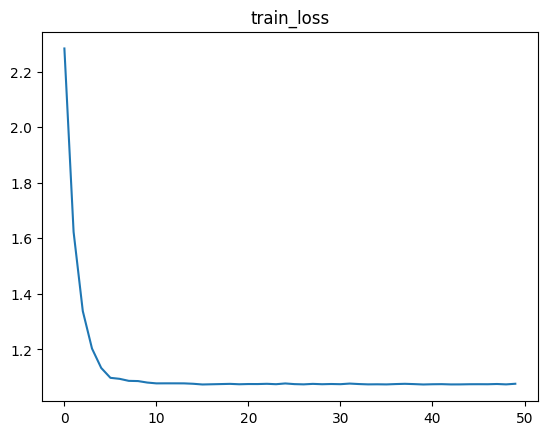

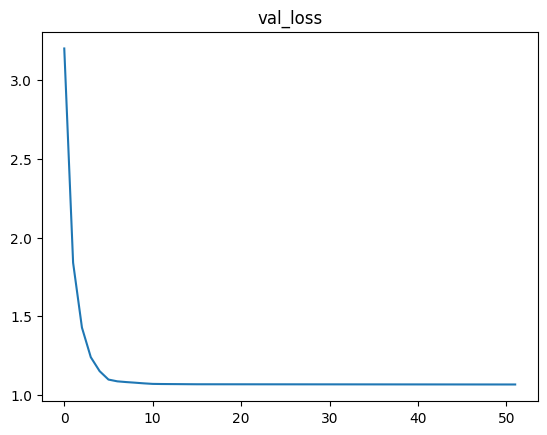

In [106]:
plt.title("train_loss")
plt.plot(range(len(train_plot)), train_plot)
plt.show()

plt.title("val_loss")
plt.plot(range(len(val_plot)), val_plot)
plt.show()

In [118]:
@torch.no_grad()
def generate(model: RNN_max, idx: Tensor, c: Tensor, max_new_tokens: int) -> Tensor:
    # idx: B x T
    for t in range(max_new_tokens):
        logits = model.forward(idx, c)[:, -1]  # B x T x V
        probs = F.softmax(logits, dim=1)  # B x V
        new_token = torch.multinomial(probs, 1)
        idx = torch.cat([idx, new_token], dim=1)

    return idx


In [142]:
def batch_decode(out_tokens: Tensor) -> list[str]:
    decoded_strings = []
    inverse_vocab = {VOCAB[key]: key for key in VOCAB}
    for x in out_tokens:
        x_list = x.tolist()
        tmp = ''.join([inverse_vocab[c] if inverse_vocab[c] not in SPECIAL_TOKENS else '' for c in x_list])
        decoded_strings.append(tmp)

    return decoded_strings
        

In [155]:
ans_dict = {}

for s in SPECIES:
    samples = generate(lit_module.model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.full(size=(20,), fill_value=SPECIES[s], dtype=int), max_new_tokens=130)
    batch_decode(samples)
    ans_dict[s] = batch_decode(samples)
    

In [145]:
! pip install biopython==1.84

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 123.5 kB/s eta 0:00:00a 0:00:01


In [146]:
from Bio.Align import PairwiseAligner


def get_sequence_score(query_sequence: str) -> float:
    references = [
        "QVQLQQPGAELVKPGASVKMSCKAS_WITWVKQRPGQGLEWIGDI_TNYNEKFKTKATLTVDTSSSTAYMQLSSLTSEDSAVYYCAR_WGQGTSVTVSS",
        "EVKLEESGGGLVQPGGSMKLSCAAS_WMDWVRQSPEKGLEWVAEI_TYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCTA_WGQGTLVTVSA",
        "HVQLVESGGGSVQPGGSLRLSCTVS_CMGWFRRAPGKEREKVATL_TSYADSVKGRFAISQDPAKNTLWLQMNSLKPEDSATYYCAA_SSRGTQVTVS",
        "QVQLVESGGGSVQAGGSLKLSCAAS_CMGWSRQAPGKGREGVARI_TAYADSVKGRFTISHDSIKNTLYLQMNSLRPEDTAKYYCAA_WGQGTQVTV",
        "QSLEESGGDLVKPGASLTLTCTAS_YMCWVRQAPGKGLEWIACI_TYYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCAS_WGQGTLVTVS",
        "QEQLVESGGGLVKPGASLTLTCKAS_VMCWVRQAPGKGLEWIACI_SVYASWAKGRSTISRTSSTTVTLQMTSLTAADTATYFCAR_RGPGTLVTVS",
        "SVKVSCKAS_WIQWVRQAPGQGLEWMGWM_TTYSPKFQGRVSMTSDKSITTAYLELRGLTSDDTAVYSCAR_WGQGTLITVTS",
    ]
    max_score = 0.0
    for ref in map(lambda s: s.replace("_", ""), references):
        alignment = PairwiseAligner().align(query_sequence, ref)[0]
        n_matches = sum(
            1 for i in range(alignment.length) if alignment[0][i] == alignment[1][i]
        )
        max_score = max(max_score, n_matches / len(ref))

    return max_score

In [147]:
get_sequence_score("HESGGGAVTVSKETLSLTLTYEDTAIYYCAKDDVGGSSYSPVCWLSWGQGTQVTVS")

0.3763440860215054

In [148]:
get_sequence_score(
    "EVQLVESGGGLVQPGGSLRLSCAASGFTFSDDGMSWVRQAPGKGLEWVAVISSDGSQKSNADSVRDRFTISKDNSKNMLYLQMNNLRLEDTAVYFCTTFSYWGQGVQVTVSS"
)

0.7340425531914894

In [ ]:
scores = {}
for s in SPECIES:
    scr=[]
    for itm in ans_dict.get(s):
        scr.append(get_sequence_score(itm))
    scores[s] = scr

scores

{'Camel': [0.3684210526315789,
  0.3118279569892473,
  0.3723404255319149,
  0.4787234042553192,
  0.45,
  0.3125,
  0.47368421052631576,
  0.35106382978723405,
  0.39361702127659576,
  0.4838709677419355,
  0.3191489361702128,
  0.525,
  0.5425531914893617,
  0.4375,
  0.525,
  0.5212765957446809,
  0.5106382978723404,
  0.5,
  0.4574468085106383,
  0.44086021505376344],
 'Human': [0.4875,
  0.2903225806451613,
  0.3473684210526316,
  0.5,
  0.59375,
  0.0875,
  0.6344086021505376,
  0.5416666666666666,
  0.375,
  0.6344086021505376,
  0.44086021505376344,
  0.5263157894736842,
  0.5851063829787234,
  0.29473684210526313,
  0.44680851063829785,
  0.5161290322580645,
  0.5833333333333334,
  0.5263157894736842,
  0.6354166666666666,
  0.5268817204301075],
 'Mouse': [0.4375,
  0.275,
  0.5,
  0.5375,
  0.5375,
  0.55,
  0.3125,
  0.25,
  0.5875,
  0.4875,
  0.4946236559139785,
  0.5376344086021505,
  0.2375,
  0.5425531914893617,
  0.5625,
  0.65,
  0.325,
  0.5268817204301075,
  0.5375,

In [166]:
for s in SPECIES:
    cnt = 0
    for scr in scores[s]:
        if scr >= 0.55:
            cnt+=1

    print(s, cnt)

Camel 0
Human 6
Mouse 4
Rabbit 2
Rhesus 1


In [159]:
class ConditionalGRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int, class_dim: int) -> None:
        super().__init__()
        self.W_r = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)
        self.W_z = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)
        self.W = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)


    def forward(self, x: Tensor, c: Tensor, h: Tensor) -> Tensor:
        z = F.sigmoid(self.W_z(torch.cat([x, c, h], dim=1)))
        r = F.sigmoid(self.W_r(torch.cat([x, c, h], dim=1)))
        h_ = F.tanh(self.W(torch.cat([x, c, h * r], dim=1)))
        h_ = (1 - z) * h + z * h_
        return h_

In [161]:

class RNN_ULTRA(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, class_dim=len(SPECIES)) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.embed_class = nn.Embedding(class_dim, 8)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = ConditionalGRUCell(hidden_dim, hidden_dim, 8)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        c = self.embed_class(c)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        logits = [] # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, c, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x hidden
            logits.append(y)
            # save prediction for step t + 1

        # lm_head: B x T x hidden -> B x T x V
        return torch.cat(logits, dim=1)



In [172]:
class LitULTRA(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:

        x, y = batch
        y_hat = self.model(x, y)
        loss = F.cross_entropy(
            y_hat[:, :-1].reshape(-1, len(VOCAB)),
            x[:, 1:].reshape(-1),
        )
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x, y)
        loss = F.cross_entropy(
            y_hat[:, :-1].reshape(-1, len(VOCAB)),
            x[:, 1:].reshape(-1),
        )
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[5, 10, 15],
                gamma=0.1,
            ),
        }
    
    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics["train_loss"]
        train_plot.append(train_loss.to(device='cpu').detach().numpy())

    def on_validation_epoch_end(self) -> None:
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_plot.append(val_loss.to(device='cpu').detach().numpy())
        print(f" Val. Loss: {val_loss:.4f}")

In [173]:
train_plot = []
val_plot = []

lit_module = LitULTRA(
    model=RNN_ULTRA(vocab_size=len(VOCAB)), learning_rate=0.004
)

datamodule = Datamodule(batch_size=32, num_workers=0)
datamodule.setup(stage="fit")

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=15,
    limit_train_batches=None,
    limit_val_batches=None,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

trainer.validate(
    model=lit_module,
    datamodule=datamodule,
)

/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RNN_ULTRA | 29.5 K | train
--------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


 Val. Loss: 3.1804


/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 1.1569


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.9437


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.8728


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.8392


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.8097


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7948


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7917


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7894


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7871


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7850


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7839


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7835


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7833


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7831


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


 Val. Loss: 0.7829


Validation: |          | 0/? [00:00<?, ?it/s]

 Val. Loss: 0.7829


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.7829179167747498     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7829179167747498}]

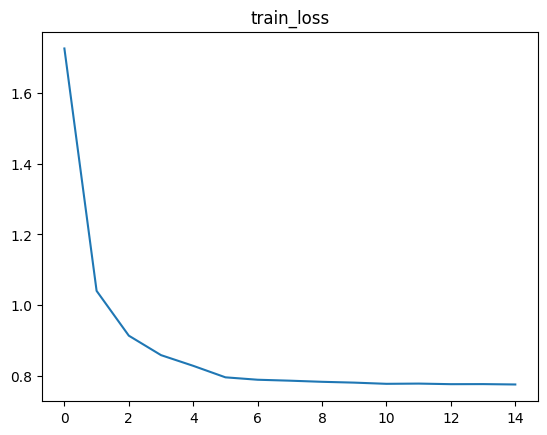

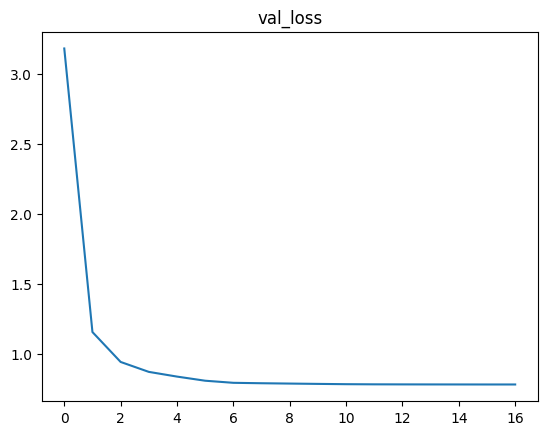

In [174]:
plt.title("train_loss")
plt.plot(range(len(train_plot)), train_plot)
plt.show()

plt.title("val_loss")
plt.plot(range(len(val_plot)), val_plot)
plt.show()

In [175]:
@torch.no_grad()
def generate(model: RNN_max, idx: Tensor, c: Tensor, max_new_tokens: int) -> Tensor:
    # idx: B x T
    for t in range(max_new_tokens):
        logits = model.forward(idx, c)[:, -1]  # B x T x V
        probs = F.softmax(logits, dim=1)  # B x V
        new_token = torch.multinomial(probs, 1)
        idx = torch.cat([idx, new_token], dim=1)

    return idx


In [176]:
ans_dict = {}

for s in SPECIES:
    samples = generate(lit_module.model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.full(size=(20,), fill_value=SPECIES[s], dtype=int), max_new_tokens=130)
    batch_decode(samples)
    ans_dict[s] = batch_decode(samples)
    

In [177]:
scores = {}
for s in SPECIES:
    scr=[]
    for itm in ans_dict.get(s):
        scr.append(get_sequence_score(itm))
    scores[s] = scr

scores

{'Camel': [0.5957446808510638,
  0.7789473684210526,
  0.30526315789473685,
  0.6914893617021277,
  0.5578947368421052,
  0.6595744680851063,
  0.7446808510638298,
  0.7789473684210526,
  0.7340425531914894,
  0.648936170212766,
  0.7446808510638298,
  0.6170212765957447,
  0.5368421052631579,
  0.5157894736842106,
  0.5473684210526316,
  0.40425531914893614,
  0.7127659574468085,
  0.7368421052631579,
  0.7021276595744681,
  0.7978723404255319],
 'Human': [0.5625,
  0.6041666666666666,
  0.7604166666666666,
  0.8020833333333334,
  0.6770833333333334,
  0.8020833333333334,
  0.5416666666666666,
  0.8125,
  0.75,
  0.5806451612903226,
  0.7708333333333334,
  0.6170212765957447,
  0.6666666666666666,
  0.8541666666666666,
  0.4791666666666667,
  0.6145833333333334,
  0.6458333333333334,
  0.5104166666666666,
  0.7604166666666666,
  0.7291666666666666],
 'Mouse': [0.725,
  0.7,
  0.7375,
  0.7125,
  0.7,
  0.475,
  0.7375,
  0.65,
  0.75,
  0.6375,
  0.65,
  0.7125,
  0.5375,
  0.625,
  0

In [178]:
for s in SPECIES:
    cnt = 0
    for scr in scores[s]:
        if scr >= 0.55:
            cnt+=1

    print(s, cnt)

Camel 15
Human 17
Mouse 16
Rabbit 19
Rhesus 18
